# 训练ResNet50模型，并保存权重

1 使用ResNet50模型

2 冻结训练分类器

3 finetune训练整个网络

4 模型预测

### 多分类问题和二分类问题基本相同，不同之处在于：

1 设置flow_flow_directory时设置二分类使用class_mode='binary'，多分类使用class_mode='categorical'。

2 模型的最后一层二分类使用Dense(1)和sigmoid激活函数，多分类要用Dense(class_num)和softmax这个多分类专用激活函数。

3 模型的loss function二分类使用loss='binary_crossentropy'，多分类要使用categorical_crossentropy。

## 预训练问题

详细可参考http://www.cnblogs.com/bonelee/p/8921311.html

## 1 import libs

In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras import optimizers
from keras.optimizers import Adam
from keras.optimizers import SGD

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Using TensorFlow backend.


## 2 build pretrained model

In [ ]:
input_tensor = Input((299, 299, 3))

base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
m_out = base_model.output
p_out = GlobalAveragePooling2D()(m_out)
p_out = Dense(256, activation='relu')(p_out)
p_out = Dropout(0.5)(p_out)
predictions = Dense(4, activation='softmax')(p_out)

for layer in base_model.layers:  
     layer.trainable = False
        
model = Model(inputs=base_model.input, outputs=predictions)
Adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/miniconda3/envs/py36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## 3 build param&pretrain

In [ ]:
epochs = 1
batch_size = 8
nb_train_samples = 126
nb_validation_samples = 20
img_size = (299, 299)

train_data_dir = '/media/data/jupyter/nannan/data/Open_I_abd_vs_CXRs/TRAIN' #location of training data
validation_data_dir = '/media/data/jupyter/nannan/data/Open_I_abd_vs_CXRs/VAL' #location of validation data

train_datagen = ImageDataGenerator(
        rescale=1./255,            # normalize pixel values to [0,1]
        zoom_range=0.2,    
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)  


val_datagen = ImageDataGenerator(
         rescale=1./255)       # normalize pixel values to [0,1]

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    img_size,
    batch_size=batch_size,
    class_mode='categorical'
    )

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)
model.save_weights("ResNet50_first_train.h5")

15/15 [==============================] - 23s 2s/step - loss: 1.6424 - acc: 0.3167 - val_loss: 1.5897 - val_acc: 0.1250


## 4 Finetune

In [ ]:
input_tensor = Input((299, 299, 3))

base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
m_out = base_model.output
p_out = GlobalAveragePooling2D()(m_out)
p_out = Dense(256, activation='relu')(p_out)
p_out = Dropout(0.5)(p_out)
predictions = Dense(4, activation='softmax')(p_out)

model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights('ResNet50_first_train.h5')

Adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
epochs = 20
batch_size = 8
nb_train_samples = 126
nb_validation_samples = 20
img_size = (299, 299)

train_data_dir = '/media/data/jupyter/nannan/data/Open_I_abd_vs_CXRs/TRAIN' #location of training data
validation_data_dir = '/media/data/jupyter/nannan/data/Open_I_abd_vs_CXRs/VAL' #location of validation data

train_datagen = ImageDataGenerator(
        rescale=1./255,            # normalize pixel values to [0,1]
        zoom_range=0.2,    
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)  


val_datagen = ImageDataGenerator(
         rescale=1./255)       # normalize pixel values to [0,1]

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    img_size,
    batch_size=batch_size,
    class_mode='categorical'
    )

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
history = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)
model.save_weights("ResNet50_finetune.h5")

Found 126 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Epoch 1/20
15/15 [==============================] - 4s 251ms/step - loss: 1.1790 - acc: 0.4667 - val_loss: 1.6634 - val_acc: 0.0625
Epoch 2/20
15/15 [==============================] - 4s 234ms/step - loss: 0.8720 - acc: 0.6309 - val_loss: 1.4613 - val_acc: 0.3333
Epoch 3/20
15/15 [==============================] - 3s 194ms/step - loss: 0.6282 - acc: 0.7696 - val_loss: 1.8167 - val_acc: 0.1250
Epoch 5/20
15/15 [==============================] - 3s 201ms/step - loss: 0.5751 - acc: 0.7638 - val_loss: 1.3452 - val_acc: 0.4167
Epoch 6/20
15/15 [==============================] - 3s 215ms/step - loss: 0.4613 - acc: 0.8415 - val_loss: 1.9701 - val_acc: 0.2500
Epoch 7/20
15/15 [==============================] - 3s 190ms/step - loss: 0.5128 - acc: 0.8029 - val_loss: 1.6870 - val_acc: 0.2500
Epoch 8/20
15/15 [==============================] - 3s 190ms/step - loss: 0.3706 - acc: 0.8806 - val_loss: 1.7378 - val_acc: 0.

## 5 Nopretrain（I think the effect is better）

In [6]:
input_tensor = Input((299, 299, 3))

base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
m_out = base_model.output
p_out = GlobalAveragePooling2D()(m_out)
p_out = Dense(256, activation='relu')(p_out)
p_out = Dropout(0.5)(p_out)
predictions = Dense(4, activation='softmax')(p_out)

model = Model(inputs=base_model.input, outputs=predictions)


Adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
batch_size = 8
nb_train_samples = 126
nb_validation_samples = 20
img_size = (299, 299)

train_data_dir = '/media/data/jupyter/nannan/data/Open_I_abd_vs_CXRs/TRAIN' #location of training data
validation_data_dir = '/media/data/jupyter/nannan/data/Open_I_abd_vs_CXRs/VAL' #location of validation data

train_datagen = ImageDataGenerator(
        rescale=1./255,            # normalize pixel values to [0,1]
        zoom_range=0.2,    
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)  


val_datagen = ImageDataGenerator(
         rescale=1./255)       # normalize pixel values to [0,1]

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    img_size,
    batch_size=batch_size,
    class_mode='categorical'
    )

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
history = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

Found 126 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Epoch 1/10
15/15 [==============================] - 31s 2s/step - loss: 1.1791 - acc: 0.5250 - val_loss: 0.5244 - val_acc: 0.8125
Epoch 2/10
15/15 [==============================] - 2s 157ms/step - loss: 0.4006 - acc: 0.8832 - val_loss: 0.1634 - val_acc: 1.0000
Epoch 3/10
15/15 [==============================] - 2s 156ms/step - loss: 0.1553 - acc: 0.9421 - val_loss: 0.0367 - val_acc: 1.0000
Epoch 4/10
15/15 [==============================] - 3s 211ms/step - loss: 0.1423 - acc: 0.9473 - val_loss: 0.0178 - val_acc: 1.0000
Epoch 5/10
15/15 [==============================] - 3s 213ms/step - loss: 0.0618 - acc: 0.9750 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 6/10
15/15 [==============================] - 3s 225ms/step - loss: 0.1805 - acc: 0.9499 - val_loss: 0.0483 - val_acc: 1.0000
Epoch 8/10
15/15 [==============================] - 4s 233ms/step - loss: 0.1742 - acc: 0.9499 - val_loss: 0.3180 - val_acc: 0.83

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


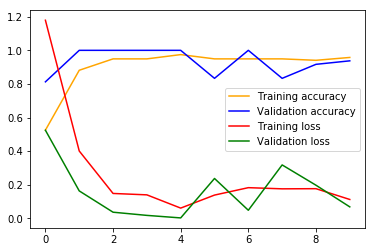

In [8]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

/media/data/jupyter/nannan/data/Open_I_abd_vs_CXRs/TEST/PMC3767900_ksrr-25-141-g004.png


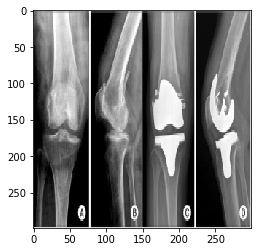

[3.5999907e-05 3.3920885e-05 2.2909693e-04 9.9970102e-01]
Predicted: 1.00 chest
/media/data/jupyter/nannan/data/Open_I_abd_vs_CXRs/TEST/chest2.png


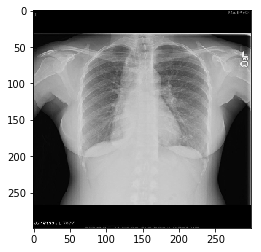

[1.7088673e-01 1.2065510e-03 1.9652388e-04 8.2771021e-01]
Predicted: 0.83 chest
/media/data/jupyter/nannan/data/Open_I_abd_vs_CXRs/TEST/abd2.png


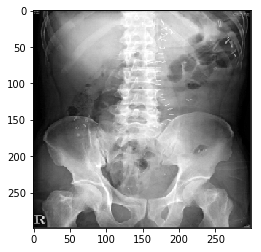

[0.00212497 0.97477585 0.00486908 0.01823004]
Predicted: 0.97 knee
/media/data/jupyter/nannan/data/Open_I_abd_vs_CXRs/TEST/PMC3341767_CCD-3-86-g010.png


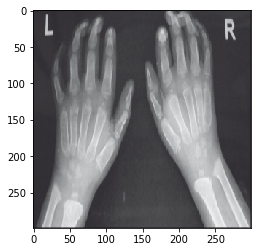

[1.8889361e-04 1.8483546e-03 9.8754406e-01 1.0418693e-02]
Predicted: 0.99 abd


In [12]:
fin = {'0': 'hand','1': 'knee','2':'abd','3':'chest'}
import numpy as np
import glob
from keras.preprocessing import image
img_width, img_height = 299, 299

img_path='/media/data/jupyter/nannan/data/Open_I_abd_vs_CXRs/TEST/*.png' #change to location of chest x-ray

path = glob.glob(img_path)
for img_path in path:
    print(img_path)
    img = image.load_img(img_path, target_size=(img_width, img_height))
  
    plt.imshow(img)
    plt.show()

    img = image.img_to_array(img)
    x = np.expand_dims(img, axis=0) * 1./255
    score = max(model.predict(x))
    print(score)
    proba = max(score)
    classxray = str(int(np.argwhere(score==proba)))
    print('Predicted:', "%.2f"%proba ,fin[classxray])


